### MDN References:

[useful pytorch reference](https://github.com/tonyduan/mixture-density-network)

[keras version](https://github.com/cpmpercussion/keras-mdn-layer)

[another keras version](https://github.com/omimo/Keras-MDN/blob/master/kmdn/mdn.py)


In [1]:
!pip install tensorflow-probability
!pip install graphviz

     |████████████████████████████████| 6.7 MB 20.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import MDN
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
from ProcessTrueStateActionData import read_df_in_chunks

from true_state_viewer import TrueStateTreeGraphViz, display_tree_pairs

import time
from IPython import display

### Load and preprocess the data 
(produce tf train+test datasets)

In [2]:
batch_size = 128
train_test_split = 0.99

LATENT_SIZE = 8 # (mdn output_dimension)
NUMBER_MIXTURES = 5

EPOCHS = 30

DATA_CAP = 2_000_000

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def get_columns_for_training():
    true_states = ["pre","blue","red"]
    ts_columns = {}
    for true_state in true_states:
        ts_columns[true_state] = []
        for node in range(13):
            ts_columns[true_state].append(f"{node}_ts_{true_state}_known_status")
            ts_columns[true_state].append(f"{node}_ts_{true_state}_access_status")
    return ts_columns

In [4]:
cols_dict = get_columns_for_training()
pre_cols, blue_cols, red_cols = cols_dict["pre"], cols_dict["blue"], cols_dict["red"]
all_cols = pre_cols + blue_cols + red_cols

In [5]:
df=pd.read_parquet("csv_data/TrueStatesObsActsRwds_1221_4000_B_Line.parquet").iloc[:DATA_CAP]
df = df[all_cols].astype("category")

In [6]:
df.memory_usage(deep=True)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index                      16000000
0_ts_pre_known_status       2000124
0_ts_pre_access_status      2000116
1_ts_pre_known_status       2000132
1_ts_pre_access_status      2000132
                             ...   
10_ts_red_access_status     2000132
11_ts_red_known_status      2000124
11_ts_red_access_status     2000132
12_ts_red_known_status      2000124
12_ts_red_access_status     2000132
Length: 79, dtype: int64

In [7]:
train_df=df.sample(frac=train_test_split,random_state=42)
train_pre_df = train_df[pre_cols]
train_blue_df = train_df[blue_cols]
train_red_df = train_df[red_cols]

test_df=df.drop(train_df.index)
test_pre_df = test_df[pre_cols]
test_blue_df = test_df[blue_cols]
test_red_df = test_df[red_cols]

train_size = train_df.shape[0]
test_size = test_df.shape[0]

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
print(train_size)

1980000


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(((train_pre_df.values,train_blue_df.values),train_red_df.values)).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(((test_pre_df.values,test_blue_df.values),test_red_df.values)).shuffle(test_size).batch(1))

In [10]:
for row in train_dataset.take(1):
  print(row)

((<tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 0, 2, 2],
       [0, 0, 2, ..., 0, 2, 2]])>, <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 0, 2, 2],
       [0, 0, 2, ..., 0, 2, 2]])>), <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 0, 2, 2],
       [0, 0, 2, ..., 0, 2, 2]])>)


### Create an MDN based model with pretrained encoder/decoder layers

In [16]:
class RedTSPrediction(tf.keras.Model):

    def __init__(self, vae_path, latent_size, num_mixtures):
        super().__init__()
        self.ts_vae = tf.keras.models.load_model(vae_path)
        self.ts_vae.trainable = False
        self.encoder = self.ts_vae.encoder
        self.decoder = self.ts_vae.decoder

        self.ts_dense = tf.keras.layers.Dense(1024, activation=tf.nn.relu)
        self.cross_dense = tf.keras.layers.Dense(4096, activation=tf.nn.relu)
        
        self.fc_1 = tf.keras.layers.Dense(4096, activation=tf.nn.relu)

        self.mdn = MDN.MDN(output_dimension=latent_size, num_mixtures=num_mixtures)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None,78], dtype=tf.float32)])
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return z
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32),tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def reparameterize(self, mean, logvar):
        #     eps = tf.random.normal(shape=mean.shape)
        eps = tf.random.normal(shape=tf.shape(mean))

        return eps * tf.exp(logvar * .5) + mean
 
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def decode(self, latent, apply_sigmoid=False):
        logits = self.decoder(latent)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
        return logits #self.decoder(latent_pred)

    @tf.function#(input_signature=[tf.TensorSpec(shape=[None,26], dtype=tf.uint8),tf.TensorSpec(shape=[None,26], dtype=tf.uint8)])
    def call(self, inputs):
        pre_ts = inputs[0]
        blue_ts = inputs[1]
        
        pre_ts_oh = tf.cast(tf.reshape(tf.one_hot(pre_ts,3),(-1,78)),tf.float32)
#         pre_ts_access = tf.reshape(tf.one_hot(pre_ts[:,13:],3),(-1,39))
        
        blue_ts_oh = tf.cast(tf.reshape(tf.one_hot(blue_ts,3),(-1,78)),tf.float32)
#         blue_ts_access = tf.reshape(tf.one_hot(blue_ts[:,13:],3),(-1,39))
        
#         print(pre_ts[:,:])
#         print(pre_ts_oh)
#         print(blue_ts)
#         blue_ts_kn = K.print_tensor(blue_ts[:,:13], message='blue known = ')
#         blue_ts_known = K.print_tensor(blue_ts_known[:,:13], message='blue known OH = ')
#         print(blue_ts_known.shape)

        pre_ts_encoded = self.encode(pre_ts_oh)
#         mean, logvar = self.ts_vae.encode(pre_ts_oh)
#         mean, logvar = tf.split(self.encoder(pre_ts_oh), num_or_size_splits=2, axis=1)
#         pre_ts_encoded = self.reparameterize(mean, logvar)
        pre_ts_encoded = self.ts_dense(pre_ts_encoded)
        
        blue_ts_encoded = self.encode(blue_ts_oh)
        blue_ts_encoded = self.ts_dense(blue_ts_encoded)

        combined = tf.keras.layers.concatenate([pre_ts_encoded, blue_ts_encoded])

        combined_hidden = self.cross_dense(combined)
        
        fc = self.fc_1(combined_hidden)

        mdn_out = self.mdn(fc)

        return mdn_out
        


In [21]:
@tf.function
def forward_pass(model, x, y):
    out = model(x)
    
    y_oh = tf.reshape(tf.one_hot(y,3),(-1,78))
    y_encoded = model.encode(y_oh)
    
    return out, y_encoded

@tf.function
def decode_z(model, x):
    x_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(x,tf.float32)))
#     y_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(y,tf.float32)))
    
    return x_oh
    

@tf.function
def compute_loss(model, x, y, loss_func):
    out, y_encoded = forward_pass(model, x, y)
    
    loss = loss_func(y_encoded, out)
    
    return loss
    

@tf.function
def train_step(model, x, y, optimizer, loss_func):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
#     y_encoded = model.encode(y)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y, loss_func)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training loop

In [12]:
red_ts_predictor = RedTSPrediction('models/trueStateVAE_7_L8', latent_size=LATENT_SIZE, num_mixtures=NUMBER_MIXTURES)

In [13]:
for row in test_dataset.take(1):
#   print(row)
  out = red_ts_predictor(row[0])
  print(out)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tf.Tensor(
[[-2.1179868e-03  3.6244500e-02 -1.7986381e-01  3.3291462e-01
   3.0949807e-02 -3.3571877e-02 -1.5058097e-01 -2.4488902e-01
  -1.3672502e-01  5.6034032e-02 -1.4086106e-01  4.6781264e-03
  -1.3754016e-01 -1.0134836e-01  2.5119722e-01 -4.0824196e-01
   1.9067058e-01  7.3767856e-02 -1.7701218e-01  2.1799131e-01
  -1.9003060e-03  1.9926766e-01 -2.8401411e-01 -2.5834475e-02
  -2.3582147e-01 -4.6198051e-02  8.6594693e-02  2.3850985e-04
   3.1222925e-01 -1.2751795e-01  7.4389786e-02  8.7453082e-02
  -1.3483889e-01 -1.9408233e-02  1.2227374e-01 -2.5353983e-01
   1.1041008e-01 -5.3749159e-03 -4.4944596e-02 -1.0472686e-01
   8.9145577e-01  9.4130999e-01  1.1497808e+00  1.1018574e+00
   1.0397984e+00  1.0513984e+00  9.2240608e-01  1.1383569e+00
   1.0527142e+00  1.0940250e+00  1.0025165e+00  9.6285552e-01
   9.5457250e-01  7.6767647e-01  7.9955494e-01  1.3214015e+00
   1.0597596e+00  8.7119871e-01  1.0375562e+00  1.0713509e+00
   8.8040894e-01  9.4466883e-01  8.5019118e-01  1.0719435e+

In [15]:
# red_ts_predictor.compile(loss=get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES,red_ts_predictor.encode), optimizer=tf.keras.optimizers.Adam(),metrics=['mean_squared_error'])
# red_ts_predictor.build(((1,78),(1,78)))
red_ts_predictor.summary()


Model: "red_ts_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 true_state_vae_4 (TrueState  multiple                 121736094 
 VAE)                                                            
                                                                 
 sequential_8 (Sequential)   (None, 16)                60892016  
                                                                 
 sequential_9 (Sequential)   (None, 78)                60844078  
                                                                 
 dense (Dense)               multiple                  1152      
                                                                 
 dense_1 (Dense)             multiple                  526336    
                                                                 
 mdn (MDN)                   multiple                  174165    
                                                 

In [18]:
loss_func = MDN.get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# train_dataset=test_dataset.take(10)

# EPOCHS = 500
for epoch in range(1, EPOCHS + 1):
    count = 0
    start_time = time.time()
    for train_x, train_y in train_dataset:
        if (count %1000) == 0:
            print(f"{count}={count*batch_size} samples")
        train_step(red_ts_predictor, train_x, train_y, optimizer, loss_func)
        count += 1
    end_time = time.time()

    
    total_matches = 0
    total = 0
    nodes = 0
    sum_diffs_sqrd = 0
    state_pred_pairs = []
    state_pred_pair_tree_vis = []
    loss = tf.keras.metrics.Mean()
    for test_x, test_y in test_dataset.take(1000):#.take(10):#test_dataset:
        total += 1
        if (total %100) == 0:
            print(f"{total}={total*1} samples")
        out, y_encoded = forward_pass(red_ts_predictor, test_x, test_y)
        loss_val = loss_func(y_encoded, out)
        loss(loss_val)
        
#         sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
#         pred_oh, y_oh = decode_zs(red_ts_predictor, sampled_out, y_encoded)
        
        
#         state_pred_pairs.append([y_oh, pred_oh])
# #         state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
# #         loss(compute_loss(red_ts_predictor, test_x, test_y, loss_func))
#         diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
#     #     diffs = get_state_diff(true_state_model,test_x)
#         nodes += len(diffs.flatten())
#         diffs_sqrd = np.sum(diffs*diffs)
#         sum_diffs_sqrd += diffs_sqrd
#         if not diffs_sqrd >0:
#     #       print(diffs)
#     #     else:
#           total_matches += 1
#     #       print("Match")
    #       print(diffs)

    loss = loss.result()
    display.clear_output(wait=False)
#     print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
    print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, loss, end_time - start_time))
#     display_tree_pairs(state_pred_pair_tree_vis)

Epoch: 30, Test set loss: 4.099617958068848, time elapse for current epoch: 90.83968353271484


In [18]:
# pre_ts_encoded = red_ts_predictor.ts_vae.encode(np.zeros((1,78),dtype=np.float32))
# red_ts_predictor.ts_dense(pre_ts_encoded)

red_ts_predictor((np.zeros((1,26),dtype=np.uint8),np.zeros((1,26),dtype=np.uint8)))

red_ts_predictor.save('models/RedTSPredictionMDN_1',overwrite=True)

### Test and evaluate

In [11]:
m2 = tf.keras.models.load_model(
    'models/RedTSPredictionMDN_1',
)

In [47]:
total_matches = 0
total = 0
nodes = 0
sum_diffs_sqrd = 0
state_pred_pairs = []
state_pred_pair_tree_vis = []
state_pred_samples_correct = []

red_change_test_indices = []
no_change_indices = []

loss = tf.keras.metrics.Mean()

num_eval_samples = 10

for i, (test_x, test_y) in enumerate(test_dataset.take(1000)):#.take(10):#test_dataset:
    pre_ts = tf.reshape(tf.one_hot(test_x[0],3),(-1,2,3))
    blue_ts = tf.reshape(tf.one_hot(test_x[1],3),(-1,2,3))
    
    out, y_encoded = forward_pass(m2, test_x, test_y)
    y_oh = decode_z(m2, y_encoded)
    
#     if not ONLY_MEASURE_CHANGES or np.any(blue_ts != y_oh):
    if np.any(blue_ts != y_oh):
        red_change_test_indices.append(i)
    else:
        no_change_indices.append(i)
        
    loss_val = loss_func(y_encoded, out)
    loss(loss_val)

    y_tree_vis = TrueStateTreeGraphViz(y_oh)

    predictions = []
    pred_tree_vis = []
    pred_corrects = []
    for i in range(num_eval_samples):
        total += 1
        sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
        pred_oh = decode_z(m2, sampled_out)

        predictions.append(pred_oh)
        pred_tree_vis.append(TrueStateTreeGraphViz(pred_oh))

        diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
        diffs_sqrd = np.sum(diffs*diffs)
        sum_diffs_sqrd += diffs_sqrd

        nodes += len(diffs.flatten())
        pred_correct = not diffs_sqrd >0
        if pred_correct:
            total_matches += 1
        pred_corrects.append(pred_correct)



    state_pred_pairs.append([y_oh, predictions])

    state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(pre_ts),
                                     TrueStateTreeGraphViz(blue_ts),
                                     y_tree_vis,
                                     pred_tree_vis])

    state_pred_samples_correct.append(pred_corrects)

state_pred_samples_correct = np.array(state_pred_samples_correct)

#         state_pred_pairs.append([y_oh, pred_oh])
#     state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
#         loss(compute_loss(m2, test_x, test_y, loss_func))
#     diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
#     diffs = get_state_diff(true_state_model,test_x)
#     nodes += len(diffs.flatten())
#     diffs_sqrd = np.sum(diffs*diffs)
#     sum_diffs_sqrd += diffs_sqrd
#     if not diffs_sqrd >0:
# #       print(diffs)
# #     else:
#       total_matches += 1
#       print("Match")
#       print(diffs)

loss = loss.result()
display.clear_output(wait=False)
print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
# print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
#     .format(epoch, loss, end_time - start_time))


accuracy = 5470/10000 = 0.547, 
mean of squared diffs = 12136.0/780000=0.015558974358974359
percentage wrong = (12136.0/2)/(780000/3)=0.023338461538461537


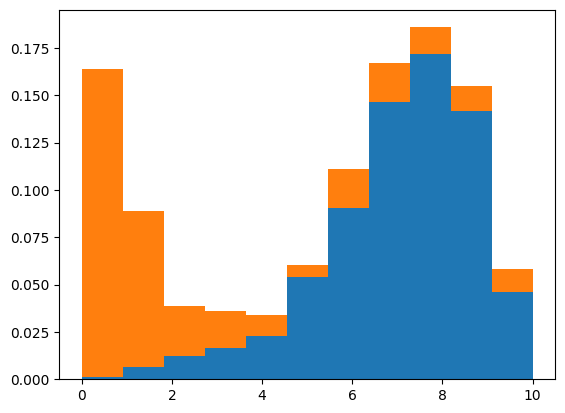

In [48]:
import matplotlib.pyplot as plt

correct_pred_counts = np.sum(state_pred_samples_correct[no_change_indices],axis=1)

correct_pred_counts_change_only = np.sum(state_pred_samples_correct[red_change_test_indices], axis=1)

# print(f"Correct prediction frequencies: {correct_pred_counts}")

plt.hist([correct_pred_counts,correct_pred_counts_change_only],num_eval_samples+1,density=True, stacked=True, label=["ALL", "ONLY CHANGES"])
# plt.hist(correct_pred_counts_change_only,num_eval_samples+1,density=True)
plt.show()

In [20]:
display_tree_pairs(state_pred_pair_tree_vis)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(IntSlider).__init__(name='Index').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


200
